Nimai Mahajan | 3/3/22

In [1]:
# IMPORTS

In [2]:
# Import core libraries
import re
import string
import numpy as np
import pandas as pd

In [3]:
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

In [4]:
# Import NLTK/training libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score

# Import some images from the web
from IPython.display import IFrame, Image
from IPython.core.display import display, display_html, HTML

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nimai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nimai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# spaCy libs (for visualization, requires spaCy)
''' 
Install with:
conda install -c conda-forge spacy
python -m spacy download en_core_web_sm
pip install scattertext
'''
import spacy
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer
nlp = spacy.load("en_core_web_sm")

In [6]:
# EDA

In [7]:
# Read CSV
df = pd.read_csv("airline_tweets.csv")

In [8]:
# Check size of data set
df.shape

(14640, 15)

In [9]:
# See how it looks
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
# Get some information about the data (columns, non-null count, etc.)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [11]:
# Calculate percentage of missing info for each column of df
def percent_missing(df):
    percent_nan = 100 * (df.isnull().sum() / df.shape[0])
    percent_nan = percent_nan[percent_nan > 0]
    return percent_nan

In [12]:
percent_missing(df).sort_values(ascending=False)

negativereason_gold          99.781421
airline_sentiment_gold       99.726776
tweet_coord                  93.039617
negativereason               37.308743
user_timezone                32.923497
tweet_location               32.329235
negativereason_confidence    28.128415
dtype: float64

In [13]:
# We can explore the columns with missing info, but we are only really concerned with 'airline_sentiment' and 'text'

In [14]:
print("Null values:")
print(df[['airline_sentiment', 'text']].isnull().sum()) # Good to go!
print("\nCount of airline_sentiment values:")
print(df['airline_sentiment'].value_counts())

Null values:
airline_sentiment    0
text                 0
dtype: int64

Count of airline_sentiment values:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


<AxesSubplot:ylabel='airline'>

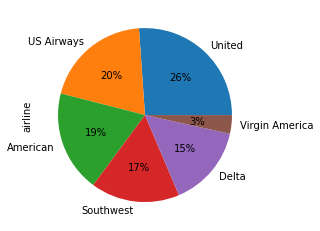

In [15]:
df['airline'].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [16]:
df.groupby(['airline','airline_sentiment'])['text'].count().unstack(level=1)

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


<AxesSubplot:xlabel='airline', ylabel='count'>

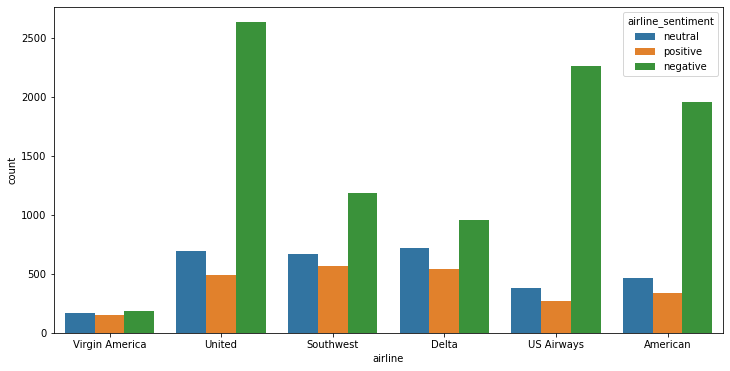

In [17]:
# Let's visualize this very important query

plt.figure(figsize=(12,6))
sns.countplot(data=df,x='airline',hue='airline_sentiment')

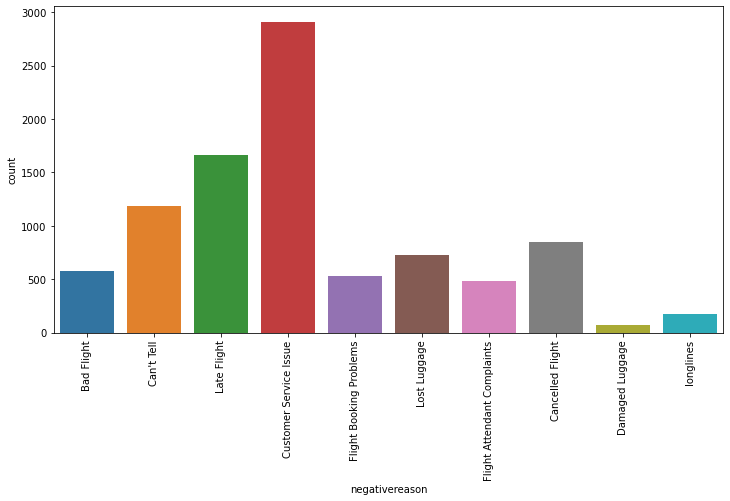

In [18]:
plt.figure(figsize=(12,6))
sns.countplot(data=df,x='negativereason')
plt.xticks(rotation=90);

In [19]:
Image(url='https://www.oreilly.com/library/view/machine-learning-with/9781789346565/assets/e322457d-6d42-4f82-999a-a2a446d5862e.png')

In [20]:
Image(url='https://qph.fs.quoracdn.net/main-qimg-cd7f4bafaa42639deb999b1580bea69f')

In [21]:
# DATA CLEANING

In [22]:
# Stop words
spacy_stop_words = {'those', 'on', 'own', '’ve', 'yourselves', 'around', 'between', 'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', '‘ll', 'doing', 'everything', 'up', 'onto', 'never', 'either', 'how', 'before', 'anyway', 'since', 'through', 'amount', 'now', 'he', 'was', 'have', 'into', 'because', 'not', 'therefore', 'they', 'n’t', 'even', 'whom', 'it', 'see', 'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 'whenever', 'seem', 'until', 'whereby', 'at', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'once', 'will', 'noone', "'m", 'that', 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'which', 'would', 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'ourselves', 'few', 'did', 'without', 'third', 'anything', 'twelve', 'against', 'while', 'twenty', 'if', 'however', 'herself', 'when', 'may', 'ours', 'six', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'where', 'otherwise', 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'others', 'show', '’s', 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'could', 'five', 'unless', 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'n‘t', 'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about', 'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 'beforehand', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from', 'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across', '‘s', '’re', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after', 'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed', 'most', 'everywhere', 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'side', 'former', 'anyone', 'full', 'has', 'yours', 'whose', 'behind', 'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 'per', 'eleven', 'ever', '‘re', 'enough', "n't", 'again', '‘d', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 'everyone', 'towards', 'this', 'cannot', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', '‘ve'}
gensim_stop_words = {'those', 'on', 'own', 'yourselves', 'ie', 'around', 'between', 'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 'cry', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', 'doing', 'everything', 'up', 'never', 'onto', 'how', 'either', 'before', 'anyway', 'since', 'through', 'amount', 'now', 'he', 'cant', 'was', 'con', 'have', 'into', 'because', 'inc', 'not', 'therefore', 'they', 'even', 'whom', 'it', 'see', 'somewhere', 'interest', 'thereupon', 'thick', 'nothing', 'whereas', 'much', 'whenever', 'find', 'seem', 'until', 'whereby', 'at', 'ltd', 'fire', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'doesn', 'once', 'will', 'noone', 'that', 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'etc', 'which', 'would', 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'thin', 'ourselves', 'few', 'did', 'third', 'without', 'twelve', 'anything', 'against', 'while', 'twenty', 'if', 'however', 'found', 'herself', 'when', 'may', 'six', 'ours', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'fill', 'where', 'otherwise', 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'eg', 'others', 'show', 'sincere', 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'de', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'km', 'could', 'five', 'unless', 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'here', 'during', 'why', 'with', 'just', 'becomes', 'about', 'a', 'co', 'using', 'seeming', 'due', 'wherever', 'beforehand', 'detail', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from', 'keep', 'him', 'or', 'top', 'her', 'didn', 'nobody', 'sometime', 'across', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 'whence', 'describe', 'under', 'always', 'himself', 'more', 'herein', 'in', 'after', 'themselves', 'you', 'them', 'above', 'sixty', 'hasnt', 'your', 'made', 'everywhere', 'indeed', 'most', 'kg', 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'computer', 'side', 'former', 'full', 'anyone', 'has', 'yours', 'whose', 'behind', 'please', 'mill', 'amoungst', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 'don', 'same', 'rather', 'really', 'latter', 'and', 'part', 'hereupon', 'per', 'eleven', 'ever', 'enough', 'again', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', 'give', 'system', 'do', 'quite', 'an', 'these', 'everyone', 'towards', 'this', 'bill', 'cannot', 'un', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 'none', 'many', 'various', 'serious', 're', 'two', 'less', 'couldnt'}
nltk_stop_words = set(stopwords.words('english'))
stop_words = spacy_stop_words | gensim_stop_words | nltk_stop_words
stop_words.add('http') # special case for instances where regex is not working for URLs
len(stop_words)

413

In [23]:
# Define preprocessing functions

# This compiles a regex object based on unicodes for all possible emojis
def remove_emojis(text): # from https://stackoverflow.com/a/58356570
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    
    text = re.sub(emoj, '', text)
    text = re.sub(r'[:;=8$-][^\s]+','', text) # remove emojis like :D or 8) or -_-
    
    return text

# This filters the text by going through stopwords and lemmatizer
def filter_and_lemmatize(text, lemmatize=False):
    tokens = []
    word_lemmatizer = WordNetLemmatizer()
    
    for token in text.split():
        if token not in stop_words:
            token = re.sub('[%s]' % re.escape(string.punctuation), '', token) # remove punctuations
            if len(token) > 2: # filter out tokens for two-letter abbreviations (e.g. bc, ik, ty, etc.)
                if lemmatize:
                    tokens.append(word_lemmatizer.lemmatize(token))
                else:
                    tokens.append(token)
    
    # return as joined string
    return ' '.join(tokens)

# This runs all the regexes on the data to remove all extraneous characters
def regex_clean(text):
    text = re.sub(r'http\S+', '', text)  # remove URls (i.e. http://somewebsite.com)
    text = re.sub(r'&amp;', '', text)    # remove literal ampersand (&amp;)
    text = re.sub(r'@[^\s]+','', text)   # remove words with users/mentions (e.g. @VirginAirlines)
    text = re.sub(r'\w*\d\w*', '', text) # remove words containing numbers (e.g. 123abc, abc123, 123abc123)

    return text
    
# Main function to preprocess text data
def preprocess_main(text):
    text = text.lower().strip() # strip whitespace and turn text into lowercase
    text = remove_emojis(text) # remove emojis / smileys
    text = regex_clean(text)
    text = filter_and_lemmatize(text, lemmatize=True)

    return text
    

In [24]:
#df['text_cleaned'] = df.apply(lambda x: preprocess_main(x['text']), axis=1)
df['text_cleaned'] = np.vectorize(preprocess_main)(df['text'])

In [25]:
# Check some filtered text (print it this way since any other way cuts off the text)
for i in range(0,10):
    print("-- ORIGINAL --:", df["text"].iloc[i])
    print("-- CLEANED --:",  df["text_cleaned"].iloc[i])

-- ORIGINAL --: @VirginAmerica What @dhepburn said.
-- CLEANED --: said
-- ORIGINAL --: @VirginAmerica plus you've added commercials to the experience... tacky.
-- CLEANED --: plus added commercial experience tacky
-- ORIGINAL --: @VirginAmerica I didn't today... Must mean I need to take another trip!
-- CLEANED --: today mean need trip
-- ORIGINAL --: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
-- CLEANED --: aggressive blast obnoxious entertainment guest face little recourse
-- ORIGINAL --: @VirginAmerica and it's a really big bad thing about it
-- CLEANED --: big bad thing
-- ORIGINAL --: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
-- CLEANED --: seriously pay flight seat playing bad thing flying
-- ORIGINAL --: @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
-- CLEANED --: yes n

In [26]:
# Let's calculate word counts to see how much we saved in preprocessing
wc_orig    = df.text.str.split().str.len().sum()
wc_cleaned = df.text_cleaned.str.split().str.len().sum()
(1 - (wc_cleaned / wc_orig)) * 100

57.353180161426366

In [27]:
# 50%+ !

In [28]:
# We can use CountVectorizer to see what the top 50 words are for negative tweets
# Inspired from https://stackoverflow.com/a/16289269

count_vectorizer = CountVectorizer(stop_words='english')

In [29]:
# Negative
matrix = count_vectorizer.fit_transform(df[df['airline_sentiment']=='negative']['text_cleaned'])
freqs = zip(count_vectorizer.get_feature_names(), matrix.sum(axis=0).tolist()[0])
sorted_freqs = sorted(freqs, key=lambda x: -x[1])
negative_freq_df = pd.DataFrame(sorted_freqs, columns=['Negative Word', 'Count'])[:20]
negative_freq_df

,Negative Word,Count
0,flight,3327
1,hour,1083
2,cancelled,920
3,customer,774
4,service,763
5,time,733
6,bag,653
7,help,612
8,hold,610
9,plane,592


In [30]:
# Let's visualize this with wordclouds

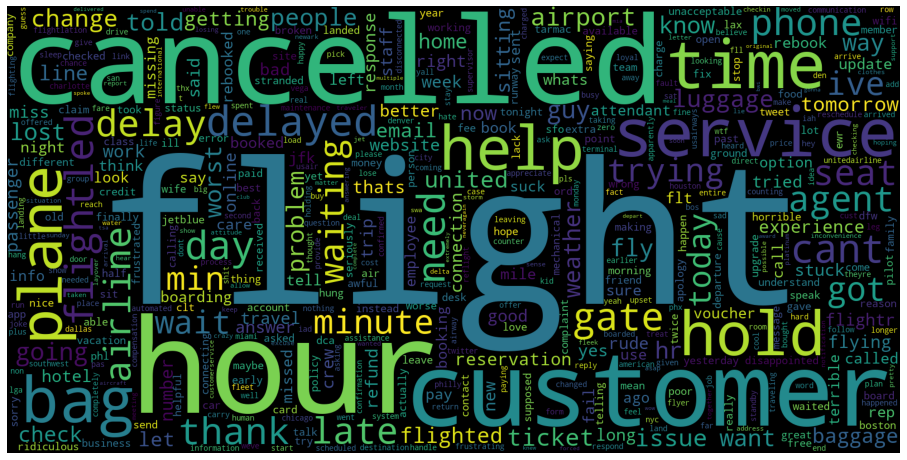

In [31]:
data_neg = df[df['airline_sentiment']=='negative']
words = ' '.join(data_neg['text_cleaned'])
plt.figure(figsize=(16,16))
wc = WordCloud(max_words=500, width=1600, height=800, collocations=False).generate(words)
plt.axis('off')
plt.imshow(wc)

In [32]:
# And now for positive

# Positive
print('Positive words:')
matrix = count_vectorizer.fit_transform(df[df['airline_sentiment']=='positive']['text_cleaned'])
freqs = zip(count_vectorizer.get_feature_names(), matrix.sum(axis=0).tolist()[0])
sorted_freqs = sorted(freqs, key=lambda x: -x[1])
positive_freq_df = pd.DataFrame(sorted_freqs, columns=['Positive Word', 'Count'])[:20]
positive_freq_df

Positive words:


,Positive Word,Count
0,thanks,609
1,thank,453
2,flight,434
3,great,233
4,service,162
5,love,133
6,customer,123
7,guy,123
8,good,110
9,airline,106


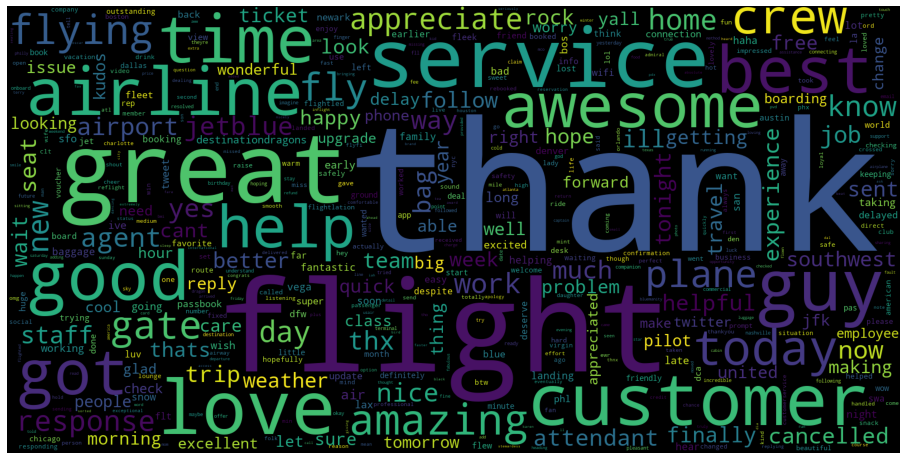

In [33]:
data_pos = df[df['airline_sentiment']=='positive']
words = ' '.join(data_pos['text_cleaned'])
plt.figure(figsize=(16,16))
wc = WordCloud(max_words=500, width=1600, height=800, collocations=False).generate(words)
plt.axis('off')
plt.imshow(wc)

In [34]:
# Let's try spaCy visualization
nlp = spacy.load("en_core_web_sm")

# Parse speech text using spaCy
df['text_cleaned_spacy'] = df.text_cleaned.apply(nlp)

# Convert dataframe into Scattertext corpus, this will take a while
corpus = st.CorpusFromParsedDocuments(df, category_col='airline_sentiment', parsed_col='text_cleaned_spacy').build()
#corpus = st.CorpusFromPandas(df, category_col="airline_sentiment", text_col="text_cleaned", nlp=nlp).build()

In [35]:
# Visualize term associations
html = produce_scattertext_explorer(corpus,
                                   category='negative',
                                   category_name='negative',
                                   not_category_name='positive',
                                   width_in_pixels=1000,
                                   minimum_term_frequency=10,
                                   #transform=st.Scalers.dense_rank
                                   #transform=st.Scalers.log_scale_standardize
                                   #transform=st.Scalers.percentile
                                   )
file_name = 'sentiments_scatter.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width=1000, height=600)
#HTML(filename=file_name)

In [36]:
# Introduce TF-IDF
Image(url='https://miro.medium.com/max/1400/1*qQgnyPLDIkUmeZKN2_ZWbQ.png')

In [37]:
# Encode feature column into TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text_cleaned'])
print(f"'text' feature transformed into {len(vectorizer.get_feature_names())} features")

'text' feature transformed into 10473 features


In [38]:
# Encode categorical labels into numerical values (skip, doesn't look like this is necessary)
encoder = LabelEncoder()
df['airline_sentiment_encoded'] = encoder.fit_transform(df['airline_sentiment'])
#0: negative, 1: neutral, 2: positive
y = df['airline_sentiment']

In [39]:
# Introduce logistic regression
# Logistic / sigmoid function is S shaped curve: σ(x) = 1 / (1+e^-x)
# In logistic regression, logistic function is used to model the probability of a certain class given an input feature X
# First question to answer is: how exactly do we use this function to model the probabilities?

Image(url='https://www.saedsayad.com/images/LogReg_1.png')

In [40]:
# Convert everything to log odds! This is written for one feature X but can be generalized for n features from i=0 to n):
# Now we get what resembles linear regression on the right hand side
# Second question may be: how to determine these coefficients?
Image(url='https://quantifyinghealth.com/wp-content/uploads/2021/05/Logistic-regression-equation.png')

In [41]:
# Take the data points and plot them on the log odds graph (they will be at +/- ∞)
# Then pick a line, project these data points onto it, and read the log odds value off the y axis
# To interpret this, transform it back into probabilities (S curve) by solving for P
# Finally, measure the likelihood of the probabilities, which is simply the product of probabilities belonging to class 1
# We want to maximize the function such that the observed data is most probable (gives us the best fit 'S')

# Rotate the log(odds) line and repeat these steps
# Ultimately we get a line that maximizes the likelihood (or minimizes log loss) and that’s the one chosen to have the best fit
Image(url='https://miro.medium.com/max/1400/1*BsiJWsQddwhFq-HMNCotTA.png')

In [42]:
# Find ideal hyperparameters for estimator with GridSearchCV

# Initialize model
log_model = LogisticRegression(max_iter=1000)

# Solver
solver = ['saga', 'lbfgs', 'liblinear']

# Penalty Type
penalty = ['l1', 'l2', 'elasticnet']

# C can be checked too but this is very slow and 1.0 is already ideal
# C np.logspace(0, 2, 5)

grid_model = GridSearchCV(estimator=log_model, param_grid=dict(penalty=penalty, solver=solver))

In [43]:
# Warnings are to be expected since not all combinations of parameters are compatible

grid_model.fit(X,y)

C:\Users\Nimai\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Nimai\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nimai\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Nimai\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Nimai\anaconda3\lib\site-packages\sklearn\model_selection\_v

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga', 'lbfgs', 'liblinear']})

In [44]:
grid_model.best_params_

{'penalty': 'l2', 'solver': 'saga'}

In [45]:
# Re-initialize model with best params
log_model = LogisticRegression(max_iter=1000, penalty='l2', solver='saga')

In [46]:
# Split train/test data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [47]:
# We have an imbalanced data set so StratifiedKFold should be used

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
accuracies = []
  
for train_index, test_index in skf.split(X, y):
    # Split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Fit to training data
    log_model.fit(X_train, y_train)
    accuracies.append(log_model.score(X_test, y_test))
  
# Print accuracy scores
print('List of possible accuracies:\n', accuracies)
print('Max/min accuracy:', max(accuracies)*100, '/', min(accuracies)*100, '%')
print('Mean accuracy:',    np.mean(accuracies)*100, '%')
print('Std deviation:',    np.std(accuracies))

List of possible accuracies:
 [0.7745901639344263, 0.7841530054644809, 0.7711748633879781, 0.7568306010928961, 0.7670765027322405, 0.76775956284153, 0.7773224043715847, 0.7718579234972678, 0.7636612021857924, 0.7773224043715847]
Max/min accuracy: 78.41530054644808 / 75.68306010928961 %
Mean accuracy: 77.11748633879782 %
Std deviation: 0.007394736941379441


In [48]:
X_train.shape

(13176, 10473)

In [49]:
X_test.shape

(1464, 10473)

In [50]:
print("Test size:", 100*(X_test.shape[0]/X.shape[0]),'%')

Test size: 10.0 %


In [51]:
# Check model coefficients after fit
log_model.coef_

array([[ 0.20659054,  0.02086199,  0.04764587, ...,  0.02452802,
         0.08641603,  0.05364226],
       [-0.0674174 , -0.01691782, -0.00884055, ..., -0.0217486 ,
        -0.05955168,  0.00286612],
       [-0.13917314, -0.00394417, -0.03880533, ..., -0.00277942,
        -0.02686434, -0.05650838]])

In [52]:
coef_df = pd.DataFrame(log_model.coef_, columns=vectorizer.get_feature_names(), index=['negative', 'neutral', 'positive'])

In [53]:
# Get 20 most weighted negative terms as fitted by the model
coef_df.T.nlargest(20, 'negative')

,negative,neutral,positive
hour,3.949049,-1.861040,-2.088009
worst,3.471026,-1.738835,-1.732191
delayed,2.887432,-1.508360,-1.379072
hold,2.640390,-0.968011,-1.672379
cancelled,2.631205,-1.349591,-1.281613
bag,2.560232,-1.535826,-1.024406
luggage,2.421370,-1.359282,-1.062088
hr,2.327784,-1.301324,-1.026461
fail,2.286911,-1.433828,-0.853083
stuck,2.195099,-1.067153,-1.127947


In [54]:
# Get 20 most weighted positive terms as fitted by the model
coef_df.T.nlargest(20, 'positive')

,negative,neutral,positive
thank,-4.289209,-0.050962,4.340171
thanks,-3.658767,-0.495855,4.154622
great,-1.975730,-2.007966,3.983696
awesome,-2.259001,-1.601635,3.860636
best,-1.623351,-1.652377,3.275727
love,-2.401415,-0.865243,3.266657
amazing,-2.008757,-1.097306,3.106063
excellent,-1.634595,-1.006729,2.641324
appreciate,-1.212826,-1.368754,2.581581
kudos,-1.833966,-0.745675,2.579641


In [55]:
# Get predictions on test data
y_pred = log_model.predict(X_test)

In [56]:
# Get probabilities from log odds
y_pred_prob = log_model.predict_proba(X_test)

In [57]:
# Let's merge predictions and probabilities back into the original dataframe at the appropriate indexes
# This makes it easy to visualize

y_test_df = pd.DataFrame(data=y_test)
y_test_df['prediction'] = y_pred
y_test_df['negative_prob'] = y_pred_prob[:,0]
y_test_df['neutral_prob'] = y_pred_prob[:,1]
y_test_df['positive_prob']  = y_pred_prob[:,2]
#df.loc[y_test.index]
# concat if indexes match
df_merged = pd.merge(df,y_test_df.drop('airline_sentiment', axis=1),how = 'left',left_index = True, right_index = True)
df_with_results = df_merged[~df_merged['prediction'].isna()]
df_with_results[['text_cleaned','airline_sentiment','prediction','negative_prob','neutral_prob','positive_prob']].sample(20).sort_index()


,text_cleaned,airline_sentiment,prediction,negative_prob,neutral_prob,positive_prob
70,need change reservation virgin credit card nee...,neutral,negative,0.500392,0.490665,0.008943
553,loved respond website saw long form business n...,negative,negative,0.836737,0.104955,0.058307
1580,award longer showing available possible availa...,neutral,negative,0.549906,0.409102,0.040992
3268,problem flight today,negative,negative,0.759041,0.168079,0.072880
4167,flt major delay ground crew slow flight crew t...,negative,negative,0.946884,0.016916,0.036200
5204,cant reschedule flight online,negative,negative,0.711593,0.259139,0.029268
5315,thx managed figure trying diff confirmation bo...,negative,negative,0.660627,0.209196,0.130177
5791,itd nice answer simple want know,negative,negative,0.749326,0.147712,0.102962
6562,credit card point family way,neutral,neutral,0.368554,0.561458,0.069988
6851,great land jfk,positive,positive,0.268510,0.202898,0.528592


In [58]:
# EVALUATE MODEL
# Run metrics to compare predictions to actual results (y_pred vs y_test)

In [59]:
print(classification_report(y_test,y_pred))

# Precision: When it predicts negative tweet, it is correct 80% of the time
# Recall: It correctly identifies 95% of negative tweets
# F1 Score: Harmonic mean between precision and recall

              precision    recall  f1-score   support

    negative       0.79      0.95      0.86       918
     neutral       0.66      0.44      0.53       309
    positive       0.84      0.57      0.68       237

    accuracy                           0.78      1464
   macro avg       0.76      0.65      0.69      1464
weighted avg       0.77      0.78      0.76      1464



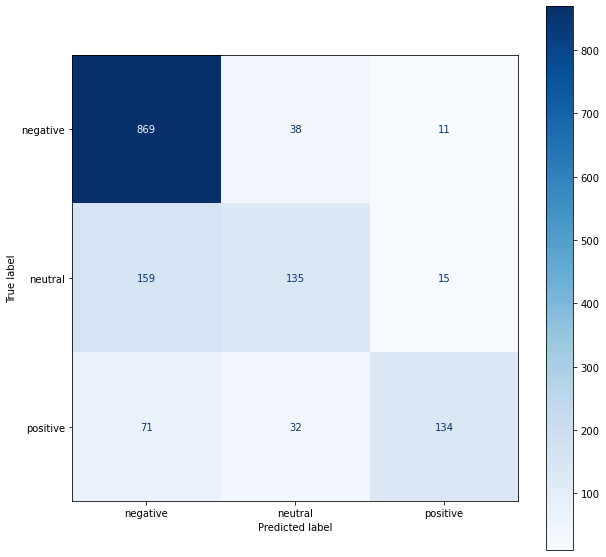

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(log_model,X_test,y_test,cmap=plt.cm.Blues,ax=ax) # This is a built in sklearn function

In [61]:
Image(url= "https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg")

In [62]:
# This is from the ROC curve documentation on sklearn and Jose Portilla's DS class notebook
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

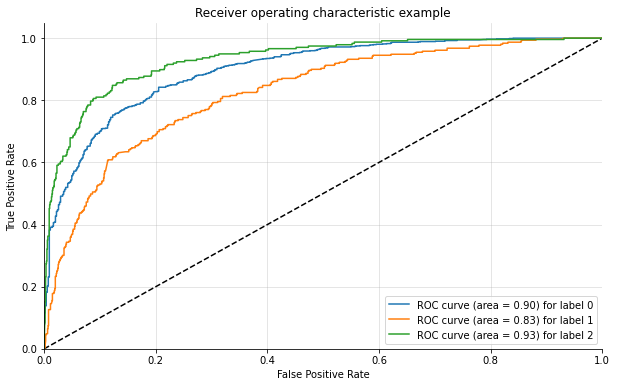

In [63]:
plot_multiclass_roc(log_model, X_test, y_test, n_classes=3, figsize=(10,6))

In [64]:
#Colors: green: negative, blue: positive, orange: neutral

In [65]:
# Let's try another model to compare (Naive Bayes also works well for NLP/probabilities)

In [66]:
# Introduce Naive Bayes
Image(url='https://wiki.pathmind.com/images/wiki/bayes_theorem.jpg')

In [67]:
# Model the probability of belonging to a certain class j given a vector/predictor x of features
# This is just Bayes Theorem!
# If each feature (predictor) x is independent of every other feature, then the probability a data-point (x1, x2 …, xk)...
#  is in Classj is simply the product of all the individual probabilities of feature xi in Classj

Image(url='http://shatterline.com/blog/wp-content/uploads/2013/09/bayes-pictorial5.png')

In [68]:
# Example of NB
# Math is simply the product of feature likelihoods given it belongs to a certain class x prior probability of the class
Image(url='https://miro.medium.com/max/1400/0*An17vvS7gI7GF1Mq')

In [69]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

In [70]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.69      0.99      0.82       918
     neutral       0.74      0.19      0.30       309
    positive       0.86      0.27      0.41       237

    accuracy                           0.70      1464
   macro avg       0.77      0.48      0.51      1464
weighted avg       0.73      0.70      0.64      1464



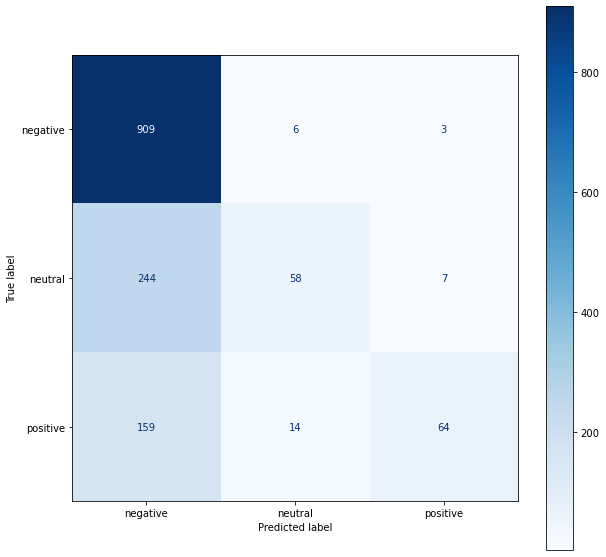

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(nb_model,X_test,y_test,cmap=plt.cm.Blues,ax=ax)

In [72]:
# Big improvement in false positives, but also labels positive and neutral tweets as negative
# Depending on what is more important, either model can be chosen based on performance metrics

In [73]:
# Let's try one final model based on boosting: xgboost
import xgboost as xgb

In [74]:
# Introduce xgboost

# XGBoost is a decision-tree-based ensemble ML algorithm that uses gradient boosting.
# It works by creating a strong classifier based on an ensemble of previous ‘weak learners'.
# Random forest: get entire collection of decision trees from the top down all at once, fits the data "hard"
 # vs. boosting: build forest from the ground up in series one at a time, learns on training data slowly

# The errors of the previous model are corrected by the next predictor by minimizing the residual error.
# This occurs iteratively until the training data is accurately reproduced by the model.

In [75]:
Image(url='https://miro.medium.com/max/1400/1*QJZ6W-Pck_W7RlIDwUIN9Q.jpeg')

In [76]:
Image(url='https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-030-34482-5_25/MediaObjects/482246_1_En_25_Fig2_HTML.png')

In [77]:
# Huge flexibility in gradient boosting models (it's a catch all framework that does very well in the real world)
# 1) Solve any kind of problem: regression, classification, ranking
# 2) Use any loss function as long as it's differentiable
# 3) Use any weak learner underneath

In [78]:
xg_model = xgb.XGBClassifier(use_label_encoder=True, eval_metric='merror', learning_rate=0.3, max_depth=10, n_estimators=200)
xg_model.fit(X_train,y_train)

C:\Users\Nimai\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=24,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [79]:
feat_import = xg_model.feature_importances_
imp_feat_df = pd.DataFrame(data=feat_import, index=vectorizer.get_feature_names(), columns=['Importance'])
imp_feat_df = imp_feat_df[imp_feat_df['Importance']>0.0005].sort_values('Importance', ascending=False)[:25]

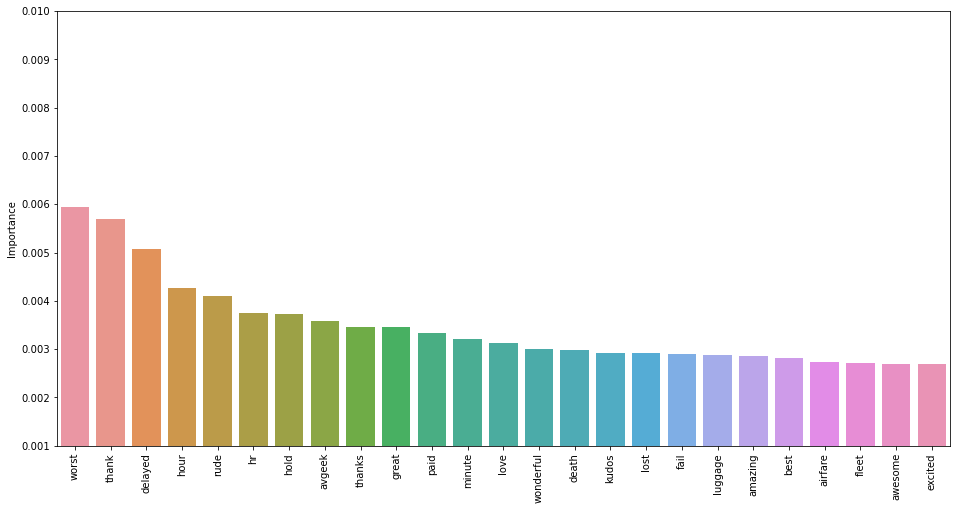

In [80]:
plt.figure(figsize=(16,8))
sns.barplot(data=imp_feat_df, x=imp_feat_df.index, y='Importance')
plt.xticks(rotation=90);
plt.ylim(0.001, 0.01);

In [81]:
y_pred = xg_model.predict(X_test)

In [82]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.81      0.91      0.86       918
     neutral       0.62      0.46      0.53       309
    positive       0.75      0.64      0.69       237

    accuracy                           0.77      1464
   macro avg       0.73      0.67      0.69      1464
weighted avg       0.76      0.77      0.76      1464



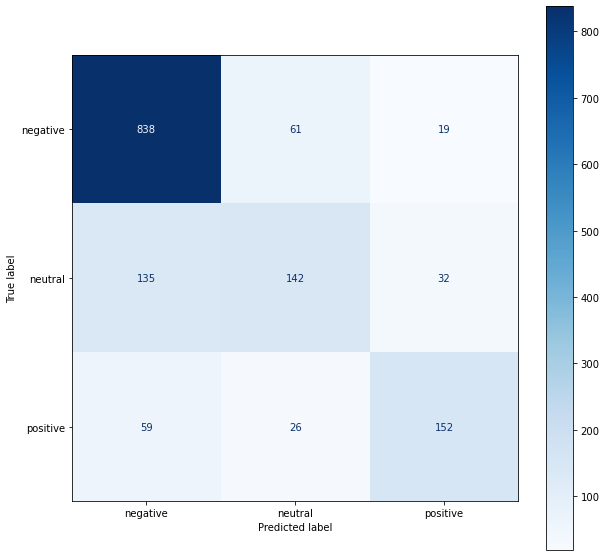

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(xg_model,X_test,y_test,cmap=plt.cm.Blues,ax=ax)

In [84]:
# PIPELINE (Simplified)

In [85]:
# Set up pipeline that can take in a tweet directly for predictions
from sklearn.pipeline import Pipeline
pipe = Pipeline([
                ('tfidf',TfidfVectorizer(stop_words='english')),
                ('model',LogisticRegression(max_iter=1000, penalty='l2', solver='saga'))
                ])
pipe.fit(df['text_cleaned'],df['airline_sentiment'])

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('model', LogisticRegression(max_iter=1000, solver='saga'))])

In [86]:
test_pos_tweet = ['This was a great flight. All compliments to the staff!']
test_neutral_tweet = ['The flight was okay overall. Nothing special.']
test_neg_tweet = ['Flight was delayed and had to wait several hours before departure. Horrible experience!']

print(pipe.predict(test_pos_tweet), pipe.predict(test_neutral_tweet), pipe.predict(test_neg_tweet))

['positive'] ['neutral'] ['negative']


In [87]:
# Conclusion / lessons learned:
'''
1) This was a great introduction to building a full model from the ground up.

2) The main goal is to be as accurate as possible with negative sentiments. 
   LogisticRegression yields decent results here as we are ~80% accurate with negative predictions.
   We can then target tweets back to these users and focus on improving customer relations.
   
3) NLP is a very complicated process. Text can always be further optimized.
   We can also utilize pos tagging, word2vec to add context/semantics, and other methods.
    
4) Neutral sentiments do not add value and confuse the estimator; group these into pos or neg class or drop it altogether.

5) Try different pretrained models that should perform a lot better to compare.

'''

'\n1) This was a great introduction to building a full model from the ground up.\n\n2) The main goal is to be as accurate as possible with negative sentiments. \n   LogisticRegression yields decent results here as we are ~80% accurate with negative predictions.\n   We can then target tweets back to these users and focus on improving customer relations.\n   \n3) NLP is a very complicated process. Text can always be further optimized.\n   We can also utilize pos tagging, word2vec to add context/semantics, and other methods.\n    \n4) Neutral sentiments do not add value and confuse the estimator; group these into pos or neg class or drop it altogether.\n\n5) Try different pretrained models that should perform a lot better to compare.\n\n'